In [19]:
import scipy
import numpy as np
from fitters import *
from tools import *
from plots import *
from projectors import *
set_seaborn()
sns.set_theme()
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
def get_data(Ydataset, factor, Xdataset='PHOTO'):
    resX, stim = read_lmc(Xdataset)
    resY, stim = read_lmc(Ydataset)
    X = preprocess(resX, factor=factor, method='mean')
    Y = preprocess(resY, factor=factor, method='mean')

    return X, Y


In [21]:

def test_run(beta=0, dt_ms=1.0, window_ms=50, dataset=''):


    factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, window_ms)

    X_series, Y_series = get_data(dataset, factor)

    P_series, theta, A = eig_companion(X_series, dim, beta=beta)
    w, vl, vr = scipy.linalg.eig(A, left=True, right=True)

    sortorder = np.argsort(np.abs(w))
    thetas = vl[:, sortorder][:, ::-1]
    thetasR = vr[:, sortorder][:, ::-1]
    w = w[sortorder][::-1]
    theta = thetas[:, 0]
    thetaR = thetasR[:, 0]

    theta /= theta[-1]
    thetaR  /= thetaR[-1]

    time = np.linspace(0,1,len(X_series))

    result = {
        'Time-X': time,
        'Time-Y': time[dim:],
        'Time-Filter': np.linspace(-window_ms, 0, dim),
        'X_series': X_series,
        'Y_series': Y_series[dim:],
        'P_series': P_series,
        'Eig Vec (REAL)': theta.real,
        'Eig Vec (IMAG)': theta.imag,
        'Eig Vec (RIGHT)': thetaR.real,
        'Eig Vals (MAG)': np.abs(w),
        'Eig Vals (REAL)': w.real,
        'Eig Vals (IMAG)': w.imag,
        'RIGHT EVs': thetasR,
        'LEFT EVs': thetas,


    }
    return result


In [22]:
ALL_DATA = ['LMC-BG1', 'LMC-BG2', 'LMC-BG3', 'LMC-BG4', 'LMC-BG5', 'LMC-BG6']
params = {
    'dataset': ['LMC-BG1'],
    'beta': [1e-1, 1e-4, 0],
    'dt_ms': [1.0, 1.5, 2.0],
    'window_ms': [50, 25, 12],

}
results = param_runner(test_run, params)


In [23]:
# mask = (results['beta'] == 1e-1) & (results['dt_ms'] == 1.5) & (results['window_ms'] == 25)
# cur = results[mask]
# left = np.swapaxes(cur['LEFT EVs'].values[0], 0, 1)
# right = np.swapaxes(cur['RIGHT EVs'].values[0], 0, 1) 

# plot_eigs(left.real, title='Left Eigs')
# plot_eigs(right.real, title='Right Eigs')

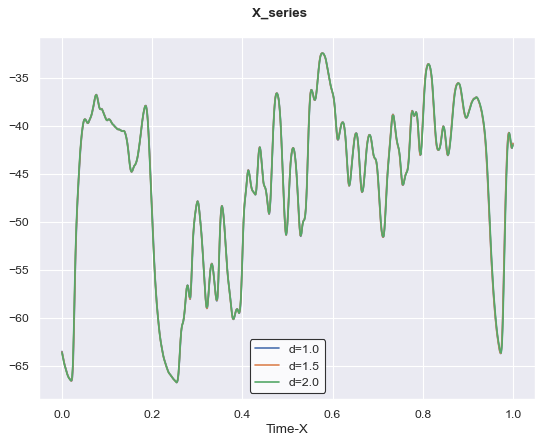

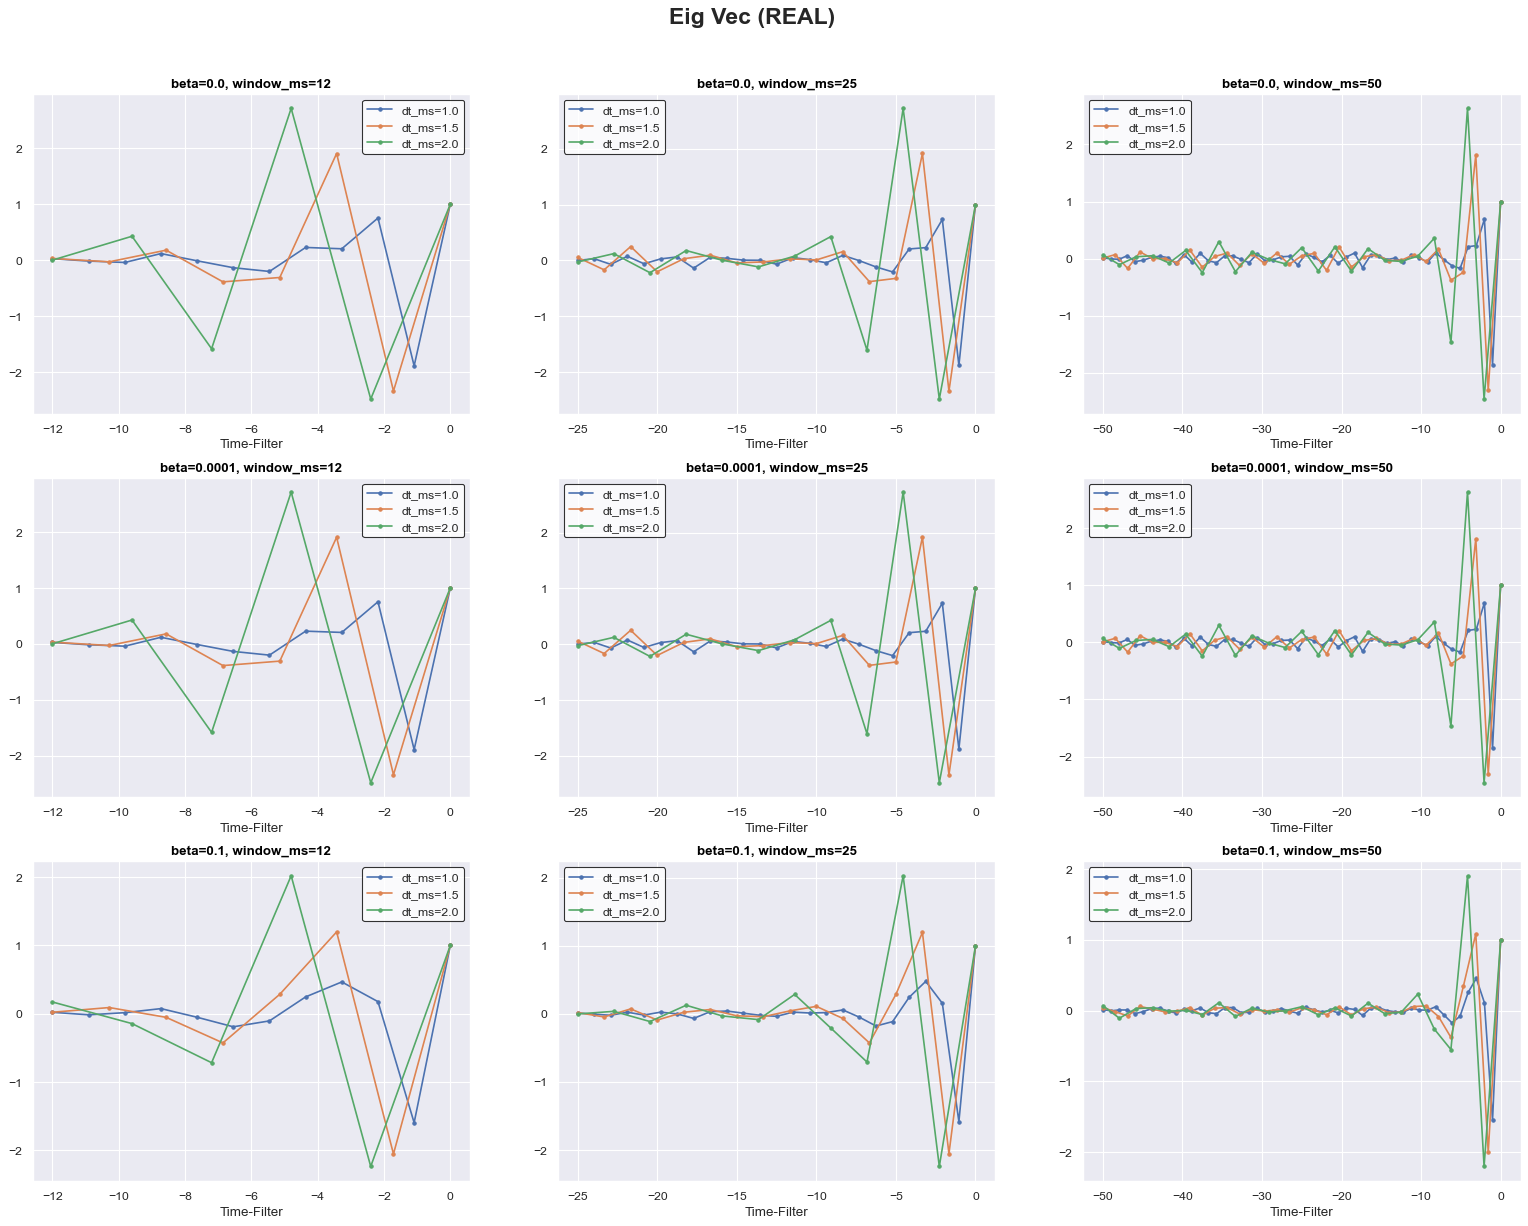

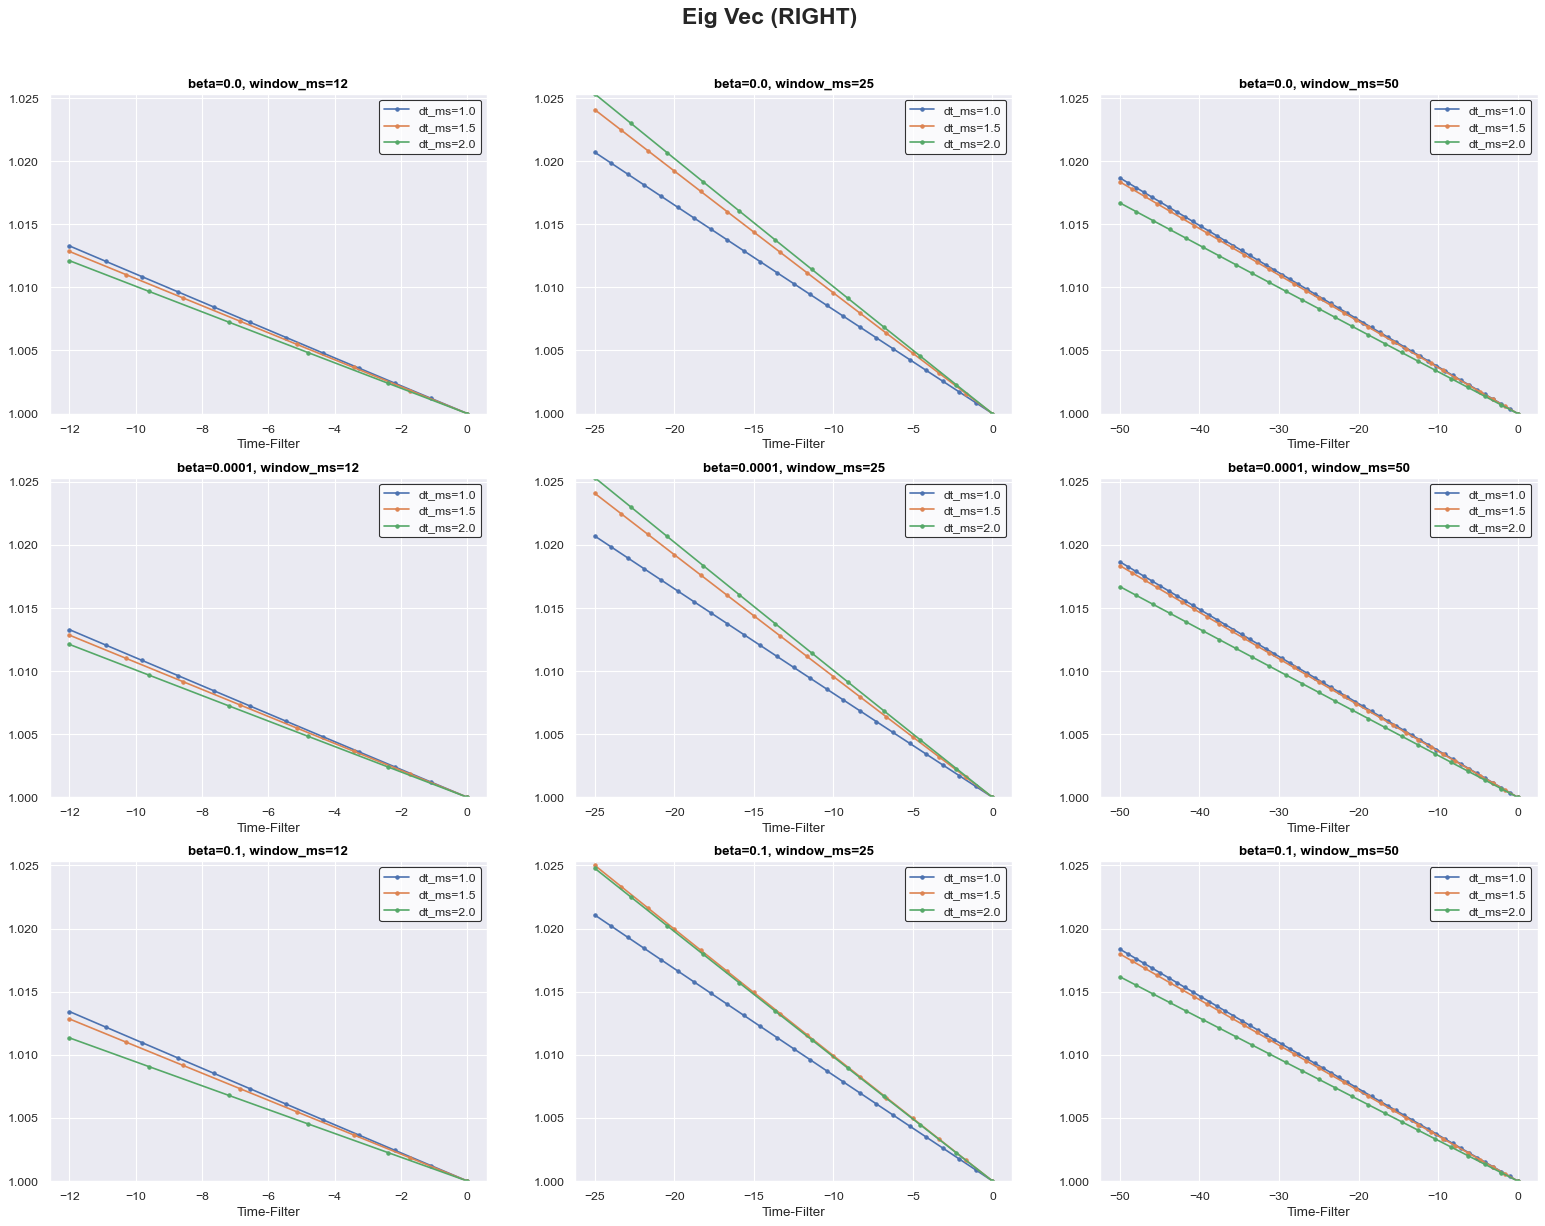

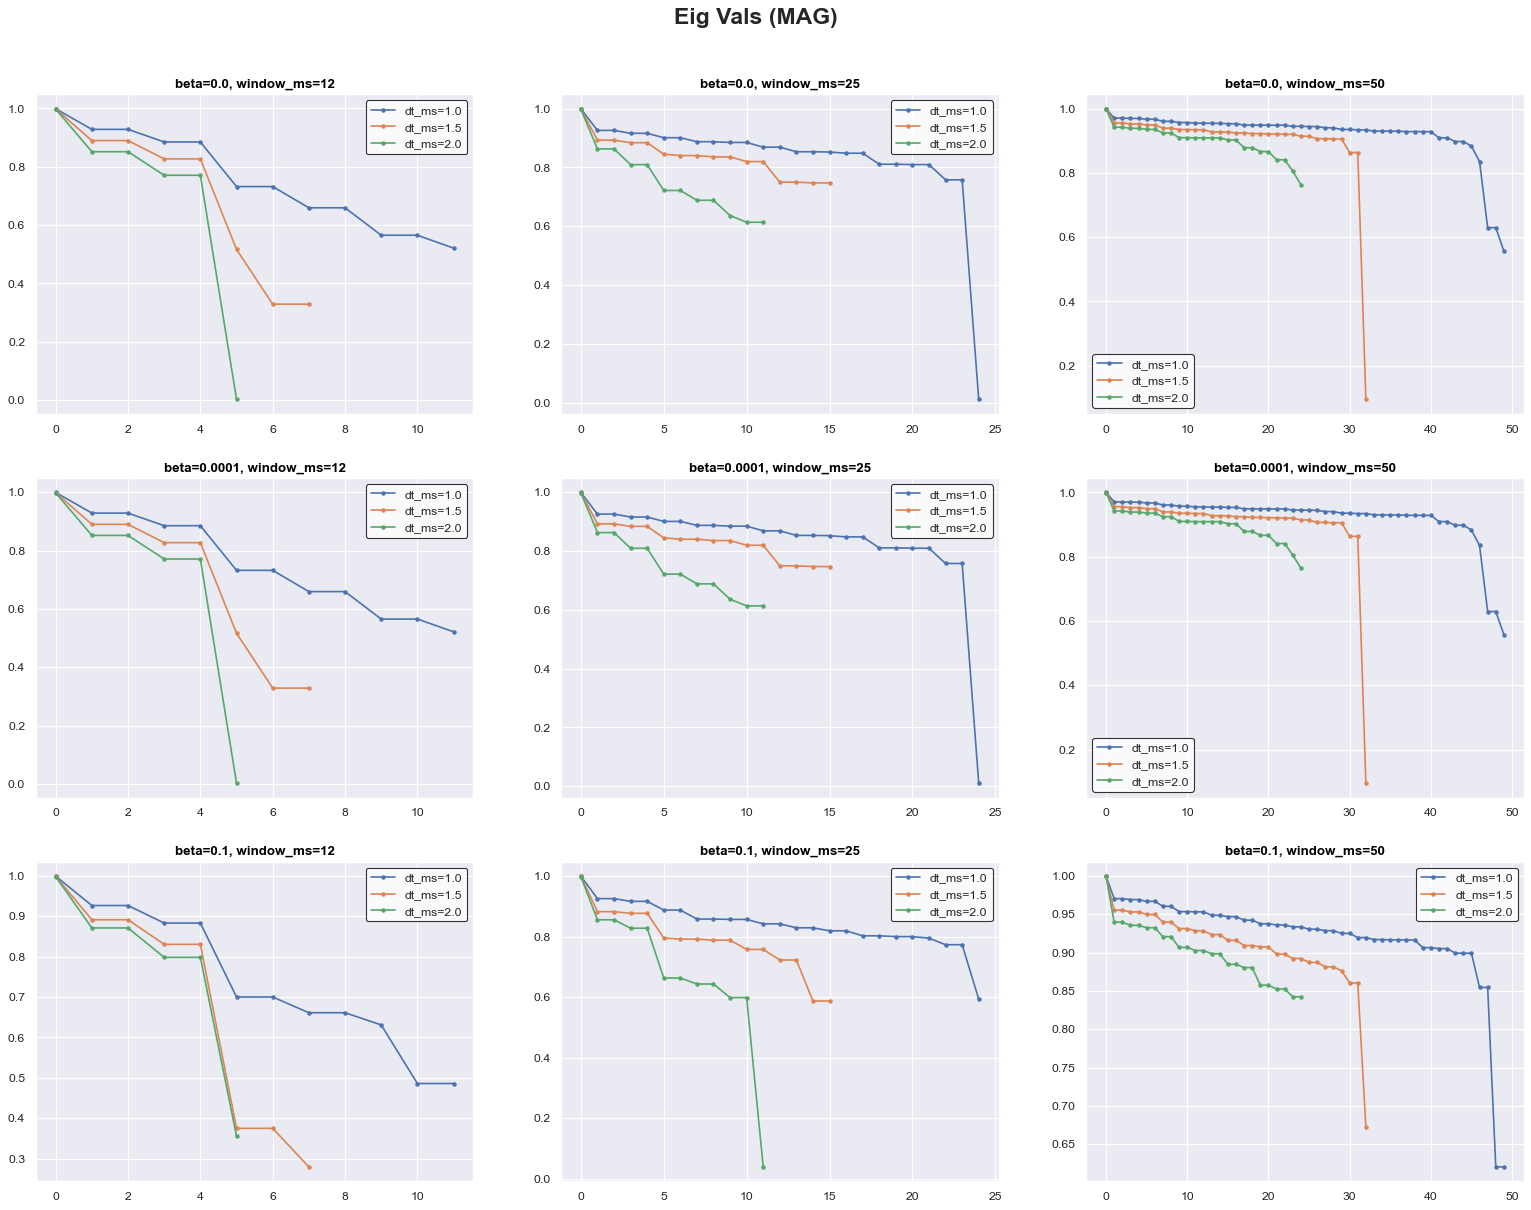

In [24]:
plot_dataframe(results, 'X_series', x_col='Time-X', line_cols='dt_ms', aggregate='last')
plot_dataframe(results, 'Eig Vec (REAL)', x_col='Time-Filter', line_cols=['dt_ms'], title_cols=['beta', 'window_ms'], val_styles=[['.-']])
plot_dataframe(results, 'Eig Vec (RIGHT)',  x_col='Time-Filter',line_cols=['dt_ms'], title_cols=['beta', 'window_ms'], val_styles=[['.-']], fix_yim=True)
plot_dataframe(results, 'Eig Vals (MAG)', line_cols=['dt_ms'], title_cols=['beta', 'window_ms'], val_styles=[['.-']])

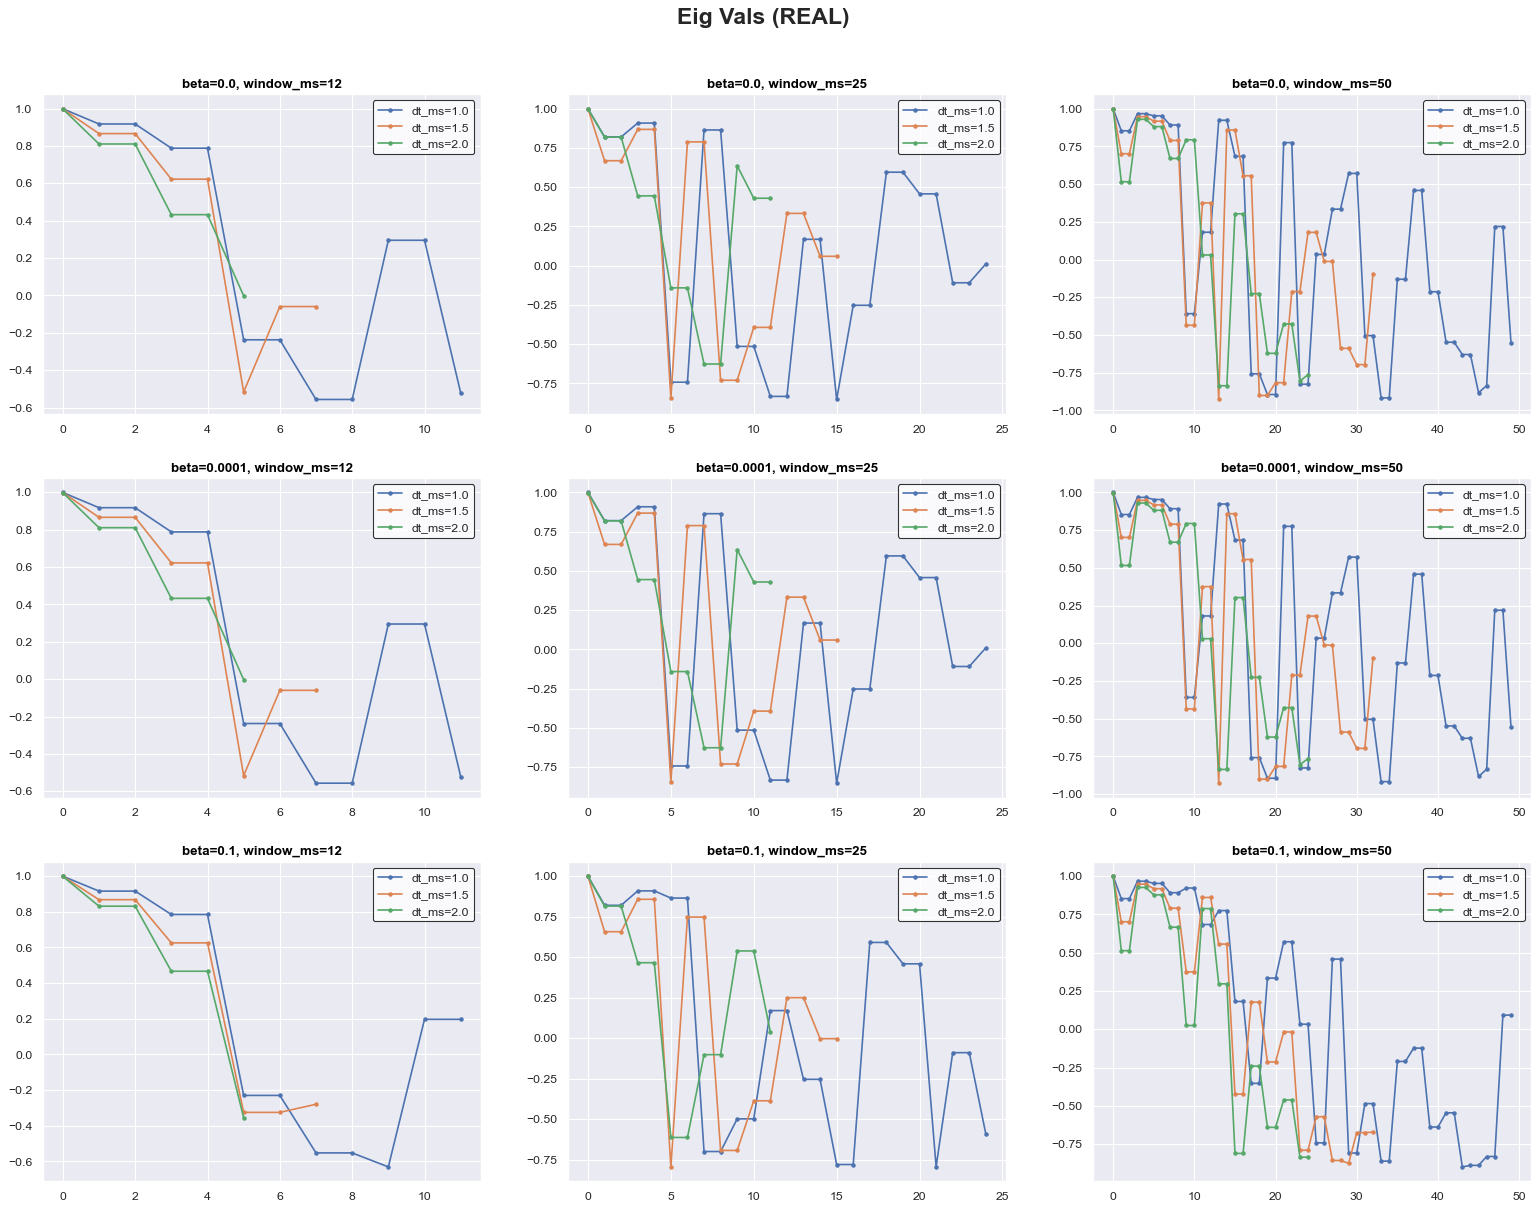

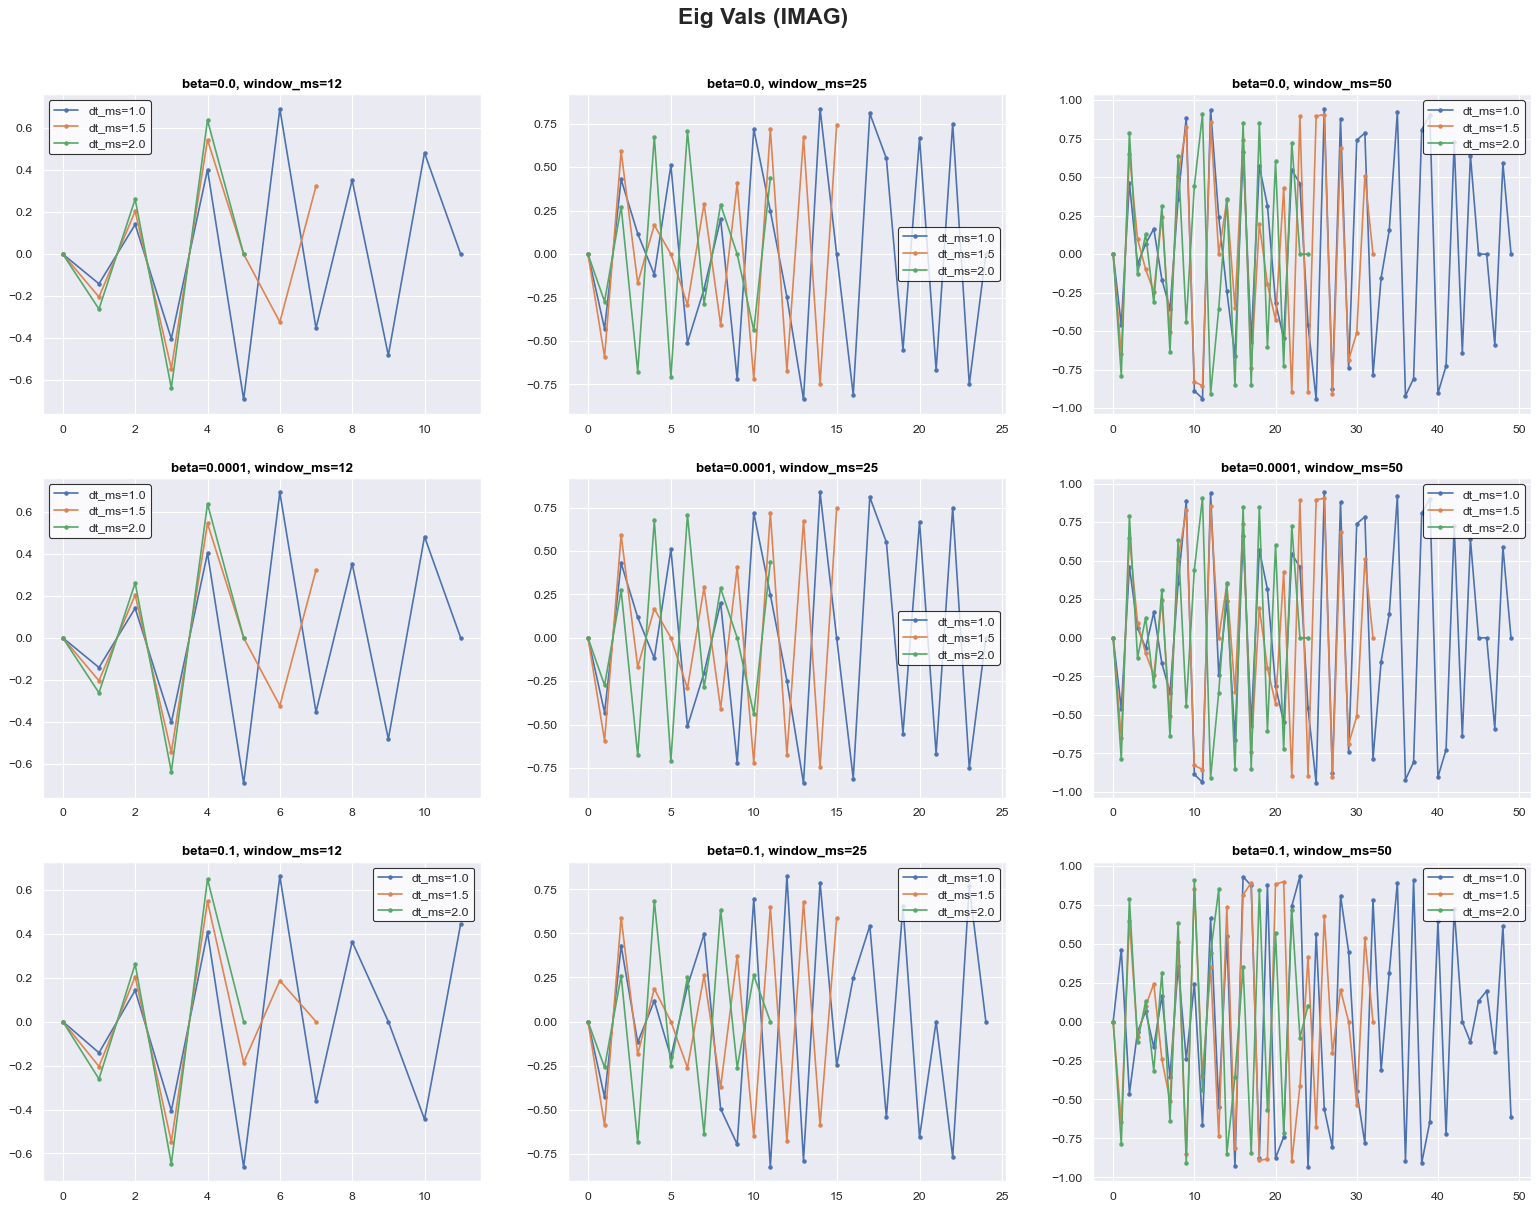

In [25]:
plot_dataframe(results, 'Eig Vals (REAL)', line_cols=['dt_ms'], title_cols=['beta', 'window_ms'], val_styles=[['.-']])
plot_dataframe(results, 'Eig Vals (IMAG)', line_cols=['dt_ms'], title_cols=['beta', 'window_ms'], val_styles=[['.-']])